In [1]:
import pickle
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker

sns.set_theme(style="whitegrid")
sns.set(style="darkgrid")

In [2]:
with open(
    "../models/smiles/full_train_augmented/all/IG_test_set_output.pkl", "rb"
) as f:
    loaded_overall_output_test = pickle.load(f)

  0%|          | 0/750 [00:00<?, ?it/s]

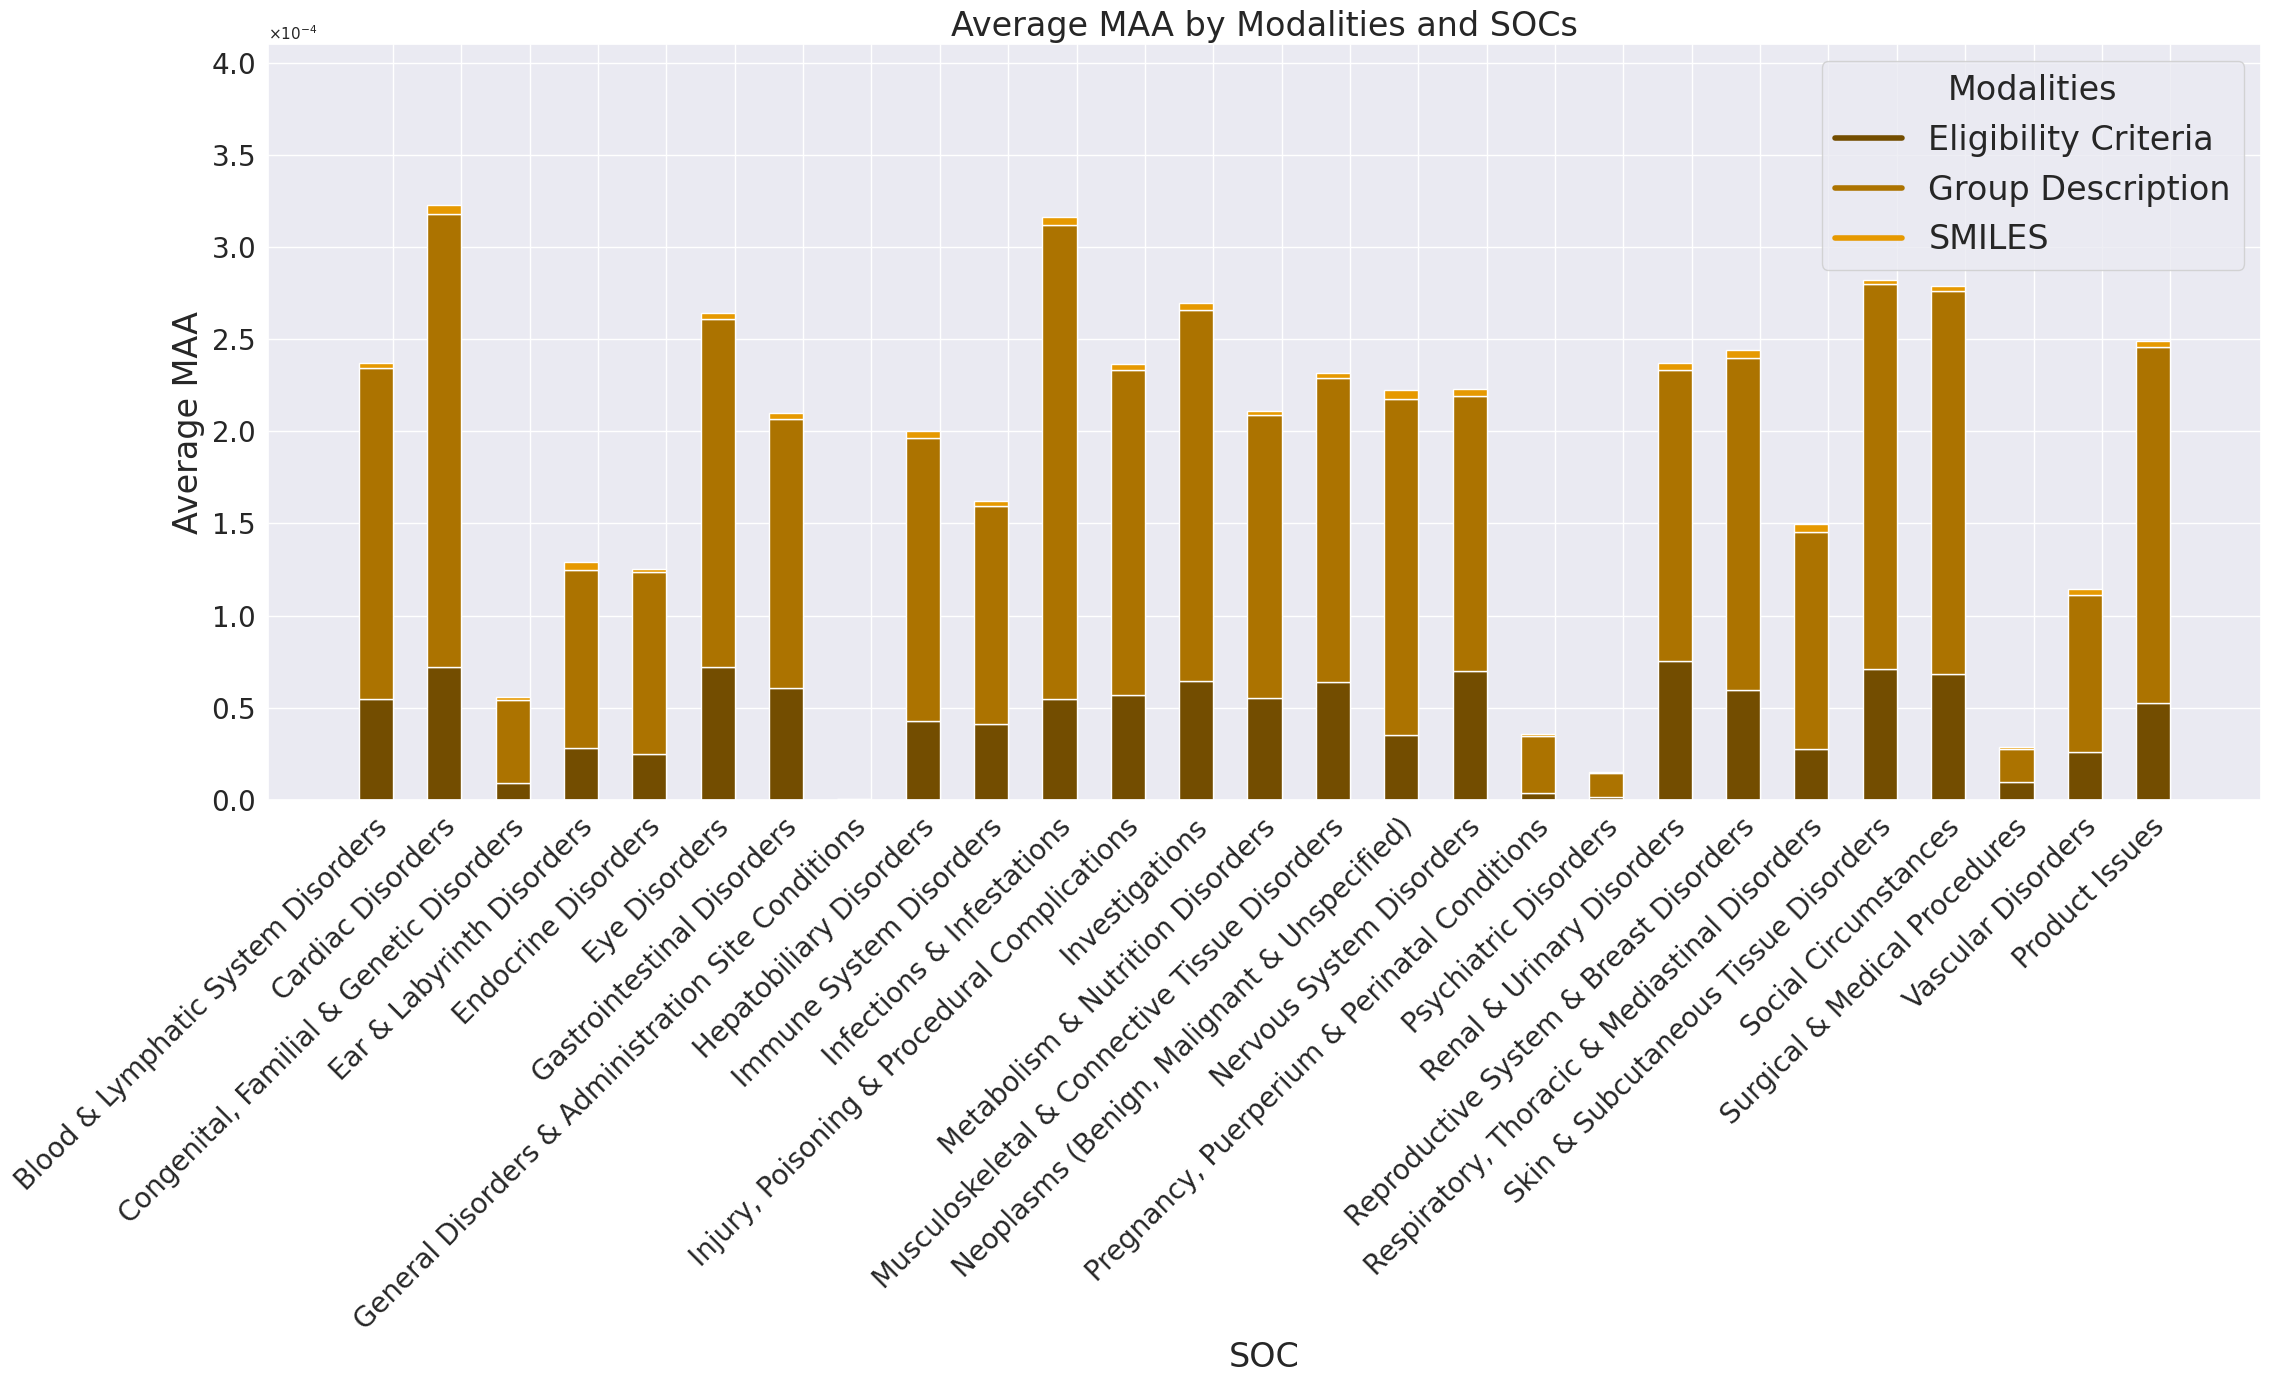

In [3]:
# Initialize dictionaries to store the lists of means for each modality
mean_abs_attributions_eligibility = {
    label: []
    for label in loaded_overall_output_test[next(iter(loaded_overall_output_test))]
}
mean_abs_attributions_group_desc = {
    label: []
    for label in loaded_overall_output_test[next(iter(loaded_overall_output_test))]
}
mean_abs_attributions_smiles = {
    label: []
    for label in loaded_overall_output_test[next(iter(loaded_overall_output_test))]
}

# Iterate through each group_id and its output in the loaded overall_output dictionary
for group_id, output in tqdm(loaded_overall_output_test.items()):
    for label, data in output.items():
        # Append the mean of the absolute values of attributions for each modality to the corresponding list
        mean_abs_attributions_eligibility[label].append(
            np.mean(np.abs(data["attributions_eligibility"][:, 1:-1, :]))
        )
        mean_abs_attributions_group_desc[label].append(
            np.mean(np.abs(data["attributions_group_desc"][:, 1:-1, :]))
        )
        mean_abs_attributions_smiles[label].append(
            np.mean(np.abs(data["attributions_smiles"][:, 1:-1, :]))
        )

# Calculate the overall mean of means for each modality and label
for label in mean_abs_attributions_eligibility.keys():
    mean_abs_attributions_eligibility[label] = np.mean(
        mean_abs_attributions_eligibility[label]
    )
    mean_abs_attributions_group_desc[label] = np.mean(
        mean_abs_attributions_group_desc[label]
    )
    mean_abs_attributions_smiles[label] = np.mean(mean_abs_attributions_smiles[label])

# Prepare data for plotting
labels = list(mean_abs_attributions_eligibility.keys())
eligibility_attributions = [
    mean_abs_attributions_eligibility[label] for label in labels
]
group_desc_attributions = [mean_abs_attributions_group_desc[label] for label in labels]
smiles_attributions = [mean_abs_attributions_smiles[label] for label in labels]

# Convert data to a format suitable for seaborn
data_for_plotting = []
for label in labels:
    data_for_plotting.append(
        ["Eligibility Criteria", label, mean_abs_attributions_eligibility[label]]
    )
    data_for_plotting.append(
        ["Group Description", label, mean_abs_attributions_group_desc[label]]
    )
    data_for_plotting.append(["SMILES", label, mean_abs_attributions_smiles[label]])

df = pd.DataFrame(
    data_for_plotting, columns=["Modality", "Label", "Mean Abs Attribution"]
)


def get_modality_color(status, modality_index, modalities_count):
    # Define aesthetic base colors for the statuses, using colorblind-friendly choices
    base_colors = {
        "Overall": np.array([0.9, 0.6, 0.0]),  # np.array([0.75, 0.75, 0.75]) grey
        "Correct": np.array([0.35, 0.7, 0.9]),  # sky blue
        "Incorrect": np.array([0.9, 0.6, 0.0]),
    }  # orange

    # Calculate color intensity variation
    intensity_variation = np.linspace(0.5, 1, modalities_count)

    # Adjust the base color based on the modality index to get lighter or darker shades
    color = base_colors[status] * intensity_variation[modality_index]

    return color


def plot_grouped_stacked_bars(dfs, titles, global_title, y_lim=None):
    df_all = pd.concat(
        [df.assign(Status=status) for df, status in zip(dfs, titles)], ignore_index=True
    )

    label_mapping = {
        "blood_and_lymphatic_system_disorders": "Blood & Lymphatic System Disorders",
        "cardiac_disorders": "Cardiac Disorders",
        "congenital_familial_and_genetic_disorders": "Congenital, Familial & Genetic Disorders",
        "ear_and_labyrinth_disorders": "Ear & Labyrinth Disorders",
        "endocrine_disorders": "Endocrine Disorders",
        "eye_disorders": "Eye Disorders",
        "gastrointestinal_disorders": "Gastrointestinal Disorders",
        "general_disorders_and_administration_site_conditions": "General Disorders & Administration Site Conditions",
        "hepatobiliary_disorders": "Hepatobiliary Disorders",
        "immune_system_disorders": "Immune System Disorders",
        "infections_and_infestations": "Infections & Infestations",
        "injury_poisoning_and_procedural_complications": "Injury, Poisoning & Procedural Complications",
        "investigations": "Investigations",
        "metabolism_and_nutrition_disorders": "Metabolism & Nutrition Disorders",
        "musculoskeletal_and_connective_tissue_disorders": "Musculoskeletal & Connective Tissue Disorders",
        "neoplasms_benign_malignant_and_unspecified_incl_cysts_and_polyps": "Neoplasms (Benign, Malignant & Unspecified)",
        "nervous_system_disorders": "Nervous System Disorders",
        "pregnancy_puerperium_and_perinatal_conditions": "Pregnancy, Puerperium & Perinatal Conditions",
        "psychiatric_disorders": "Psychiatric Disorders",
        "renal_and_urinary_disorders": "Renal & Urinary Disorders",
        "reproductive_system_and_breast_disorders": "Reproductive System & Breast Disorders",
        "respiratory_thoracic_and_mediastinal_disorders": "Respiratory, Thoracic & Mediastinal Disorders",
        "skin_and_subcutaneous_tissue_disorders": "Skin & Subcutaneous Tissue Disorders",
        "social_circumstances": "Social Circumstances",
        "surgical_and_medical_procedures": "Surgical & Medical Procedures",
        "vascular_disorders": "Vascular Disorders",
        "product_issues": "Product Issues",
    }

    labels = df_all["Label"].unique()
    labels = [label_mapping[i] for i in labels]
    modalities = df_all["Modality"].unique()
    statuses = df_all["Status"].unique()

    fig, ax = plt.subplots(figsize=(23, 14))  # Increase figure size
    bar_width = 0.5
    r = np.arange(len(labels))

    for i, status in enumerate(statuses):
        offset = [x + bar_width * i for x in r]

        summed_attributions = (
            df_all[df_all["Status"] == status]
            .groupby(["Label", "Modality"])["Mean Abs Attribution"]
            .sum()
            .unstack()
        )
        summed_attributions = summed_attributions.reindex(columns=modalities)

        bottom = np.zeros(len(labels))

        for j, modality in enumerate(modalities):
            # Use the new function to get the color based on the status and modality index
            color = get_modality_color(status, j, len(modalities))
            ax.bar(
                offset,
                summed_attributions[modality],
                width=bar_width,
                bottom=bottom,
                color=color,
                label=f"{modality} ({status})" if i == 0 and j == 0 else "",
            )
            bottom += summed_attributions[modality].values

    ax.set_title(global_title, fontsize=24)
    ax.set_ylabel("Average MAA", fontsize=24)
    ax.set_xlabel("SOC", fontsize=24)
    ax.set_xticks(
        [r + bar_width / 2 for r in range(len(labels))]
    )  # Adjust the xticks position
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=20)

    # Set y-axis limits if y_lim argument is provided
    if y_lim is not None:
        ax.set_ylim(y_lim)

    ax.tick_params(axis="y", labelsize=20)
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.major.formatter.set_powerlimits((0, 0))

    # Create custom legend
    custom_lines = []
    for status in statuses:
        for j in range(len(modalities)):
            color = get_modality_color(status, j, len(modalities))
            legend_label = (
                f"{status} - {modalities[j]}" if len(titles) > 1 else f"{modalities[j]}"
            )
            custom_lines.append(
                plt.Line2D(
                    [0], [0], color=color, lw=4, linestyle="-", label=legend_label
                )
            )
    ax.legend(
        handles=custom_lines,
        title="Modalities",
        title_fontsize=24,
        loc="upper right",
        fontsize=24,
    )

    plt.tight_layout()
    plt.show()


# Usage examples
plot_grouped_stacked_bars(
    [df], ["Overall"], "Average MAA by Modalities and SOCs", y_lim=(0, 0.00041)
)

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

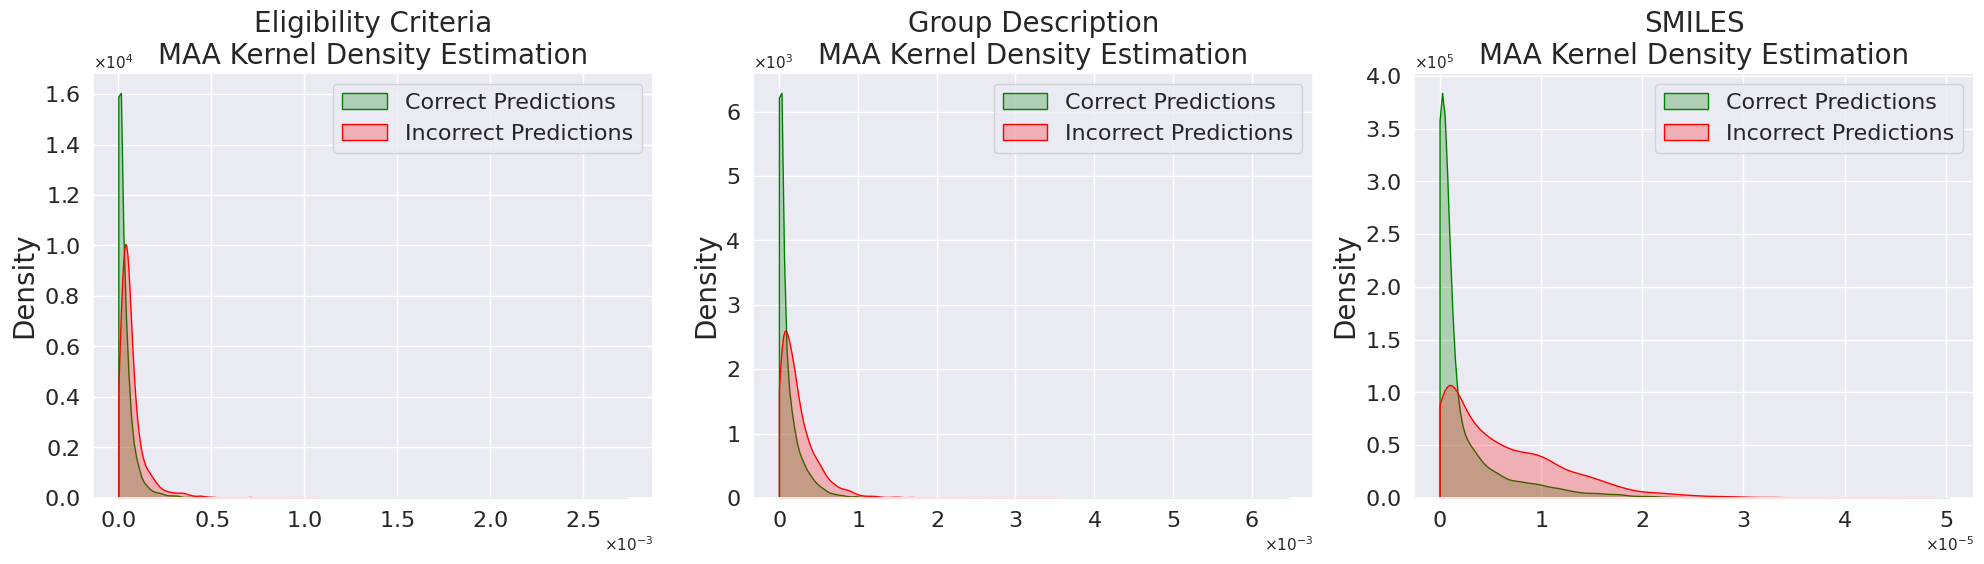

In [4]:
# Prepare the data
modality_datasets_test = []
for group_id, output in tqdm(loaded_overall_output_test.items()):
    for label_name, data in output.items():
        elig = np.mean(np.abs(data["attributions_eligibility"][:, 1:-1, :]))
        group = np.mean(np.abs(data["attributions_group_desc"][:, 1:-1, :]))
        smiles = np.mean(np.abs(data["attributions_smiles"][:, 1:-1, :]))
        modality_datasets_test.extend(
            [
                [
                    elig,
                    data["predicted_prob"],
                    label_name,
                    data["true_label"],
                    "Eligibility Criteria",
                ],
                [
                    group,
                    data["predicted_prob"],
                    label_name,
                    data["true_label"],
                    "Group Description",
                ],
                [
                    smiles,
                    data["predicted_prob"],
                    label_name,
                    data["true_label"],
                    "SMILES",
                ]  
            ]
        )
modality_df_test = pd.DataFrame(
    modality_datasets_test,
    columns=["Value", "Predicted Prob", "Label Name", "True Label", "Modality"],
)

import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

label_mapping = {
    "blood_and_lymphatic_system_disorders": "Blood & Lymphatic System Disorders",
    "cardiac_disorders": "Cardiac Disorders",
    "congenital_familial_and_genetic_disorders": "Congenital, Familial & Genetic Disorders",
    "ear_and_labyrinth_disorders": "Ear & Labyrinth Disorders",
    "endocrine_disorders": "Endocrine Disorders",
    "eye_disorders": "Eye Disorders",
    "gastrointestinal_disorders": "Gastrointestinal Disorders",
    "general_disorders_and_administration_site_conditions": "General Disorders & Administration Site Conditions",
    "hepatobiliary_disorders": "Hepatobiliary Disorders",
    "immune_system_disorders": "Immune System Disorders",
    "infections_and_infestations": "Infections & Infestations",
    "injury_poisoning_and_procedural_complications": "Injury, Poisoning & Procedural Complications",
    "investigations": "Investigations",
    "metabolism_and_nutrition_disorders": "Metabolism & Nutrition Disorders",
    "musculoskeletal_and_connective_tissue_disorders": "Musculoskeletal & Connective Tissue Disorders",
    "neoplasms_benign_malignant_and_unspecified_incl_cysts_and_polyps": "Neoplasms (Benign, Malignant & Unspecified)",
    "nervous_system_disorders": "Nervous System Disorders",
    "pregnancy_puerperium_and_perinatal_conditions": "Pregnancy, Puerperium & Perinatal Conditions",
    "psychiatric_disorders": "Psychiatric Disorders",
    "renal_and_urinary_disorders": "Renal & Urinary Disorders",
    "reproductive_system_and_breast_disorders": "Reproductive System & Breast Disorders",
    "respiratory_thoracic_and_mediastinal_disorders": "Respiratory, Thoracic & Mediastinal Disorders",
    "skin_and_subcutaneous_tissue_disorders": "Skin & Subcutaneous Tissue Disorders",
    "social_circumstances": "Social Circumstances",
    "surgical_and_medical_procedures": "Surgical & Medical Procedures",
    "vascular_disorders": "Vascular Disorders",
    "product_issues": "Product Issues",
}

# Preparing for the updated plotting section
unique_label_names = modality_df_test["Label Name"].unique()
num_labels = len(unique_label_names)
modalities = [
    "Eligibility Criteria",
    "Group Description",
    "SMILES",
]


fig, axarr = plt.subplots(1, len(modalities), figsize=(20, 6))
for j, modality in enumerate(tqdm(modalities)):

    subset = modality_df_test[modality_df_test["Modality"] == modality]

    correct_predictions = (
        (subset["Predicted Prob"] > 0.5) & (subset["True Label"] == 1.0)
    ) | ((subset["Predicted Prob"] <= 0.5) & (subset["True Label"] == 0.0))
    incorrect_predictions = ~correct_predictions

    correct = subset[correct_predictions]["Value"]
    incorrect = subset[incorrect_predictions]["Value"]

    sns.kdeplot(
        correct,
        ax=axarr[j],
        label="Correct Predictions",
        fill=True,
        color="green",
        clip=(0, None),
    )
    sns.kdeplot(
        incorrect,
        ax=axarr[j],
        label="Incorrect Predictions",
        fill=True,
        color="red",
        clip=(0, None),
    )

    axarr[j].set_title(f"{modality}\nMAA Kernel Density Estimation", fontsize=20)
    axarr[j].set_ylabel("Density", fontsize=20)
    axarr[j].set_xlabel("")
    axarr[j].legend(fontsize=16)

    # Set x-axis ticker format to scientific notation
    axarr[j].tick_params(axis="x", labelsize=16)
    axarr[j].xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    axarr[j].xaxis.major.formatter._useMathText = True
    axarr[j].xaxis.major.formatter.set_powerlimits((0, 0))

    # Set y-axis ticker format to scientific notation
    axarr[j].tick_params(axis="y", labelsize=16)
    axarr[j].yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    axarr[j].yaxis.major.formatter._useMathText = True
    axarr[j].yaxis.major.formatter.set_powerlimits((0, 0))

# Adjust layout and display the plot for the current label
plt.tight_layout()
plt.show()